# Results From Conway Game of Life Simulations using CUDA


By: Ricardo Pina

## I used dev-intel14-k20 for all compuations

## TroubleShooting

Following the initial instructions from 0318-HW3_CUDA in section 1., I immediatley received the following errors after these steps:
    
    make
    echo "0 10" | ./gol
    
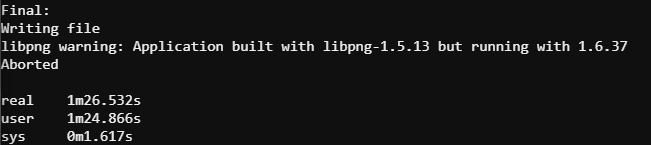

I had already loaded in the modules I thought I needed after my first attempt at using the `make` command, the modules I chose where the same ones I used in HW2, these modules being:

    module load GCCcore/9.3.0
    module load libpng/1.6.37

I figured I should try and load the libpng version the error was asking for, the version being libpng/1.5.13 , however all versions are either 1.2.58 or 1.6.xx. So what I did was load the oldest version of the 1.6.xx version. These are the following steps I took in order to get the make file and `echo "0 10" | ./gol` to run appropriately:

    module spider libpng/1.6.16
    module load impi/5.0.2.044
    module load ifort/2015.1.133-GCC-4.9.2
    module load icc/2015.1.133-GCC-4.9.2

and then I added the compiler flag for the makefile `-std=c11`

## TroubleShooting Update 3/19

I was able to get the project to work after a little bit of trouble shooting it is exactly the same as the last HW, I just needed to add the -std=c11 flag.

so in my bash files I have the following lines to run the serial code:

    module load GCCcore/9.3.0
    module load libpng/1.6.37

with the makefile having the appropriate flag

## Directions for your instructor

Include detailed instructions for compiling and reproducing the results you have in this report.  Automate as much of the steps as possible to help speed up grading.


A good idea is to show your specific commands here in the jupyter notebook.  Use the exclamation point (!) to run bash commands inside of jupyter. For example:

To get the data I used for this project I run the sbatch file in each of the directories were I solved Conways Game, and wait for the rquired time; for the serial optimized I had to wait 15 minutes for all data. Then I used this notebook to get all the data once I used git clone on my local repository for this project.

If you want to use the command line commands those also still work just use make and use the `echo "0 100 100" | ./gol`
I added a new option so now the command reads:
`echo "random dimension iterations" | ./gol`

this works for all directories.

I have a bunch of cuda and c code in cuda/gol_cuda that is probably of interest due to the changes I made.

In [ ]:
# For each Directory:

!sbatch average_time.sb

# Command line
!make
!echo "0 100 100" | ./gol

## Serial Experiment

I compiled the serial code on the intel14-k20 using the following commands:

sbatch average_time.sb

which has these important commands

    #SBATCH --nodes=1
    #SBATCH --mem-per-cpu=10000
    #SBATCH --cpus-per-task=1
    #SBATCH --time=00:10:00

    module load GCCcore/9.3.0
    module load libpng/1.6.37

I decided that it was important to see the difference in computational times with increased plate sizes, I was confused as to why the random command to run the ./gol executable did not set-up different plates for the same size, maybe the random seed was always the same. So what I did was run the code 25 times for 10 different plate sizes of increasing sizes of 25 pixels.

In [71]:
import os
import numpy as np
import matplotlib.pyplot as plt 

In [72]:
def times_extract(times):
    time_list = []
    while(True):
        line = times.readline()
        if not line:
            break
        if 'real' in line:
            time_list.append(float(line.strip()[7:12]))
    times.close
    return time_list

In [73]:
def times(n = 10, t_dir = 'serial\\serial_times\\'):
    
    cwd = os.getcwd()
    t = []
    
    for x in range(0,n):
        y = x + 1
        plate_size = 'time_{'+ f'{y*25}' + '}' + '.txt'
        time_file = os.path.join(cwd, t_dir + plate_size)
        t += [(sum(times_extract(open(time_file, 'r')))/25)]
    
    return t

In [74]:
def graph_results(t_dir = 'serial\\serial_times\\', n=10):
    
    
    fig, axs = plt.subplots(nrows=2, ncols=5, figsize=(24, 12))
    cwd = os.getcwd()
    
    for x in range(0,n):

        y = x + 1
        plate_size = 'time_{'+ f'{y*25}' + '}' + '.txt'
        time_file = os.path.join(cwd, t_dir + plate_size)
        t = times_extract(open(time_file, 'r'))

        # plot violin plot
        z = 0
        zz = 0

        if(x>4):
            z = 1
            zz = 5

        axs[z][x - zz].violinplot(t,
                          showmeans=True,
                          showmedians=False)
        
        axs[z][x - zz].set_title(f'Plate Size {y*25}')
        axs[0][0].set_ylabel('Seconds')
        axs[1][0].set_ylabel('Seconds')

    plt.show()

In [75]:
def line_plot(av_times, n = 10):
    
    plate_size = []
    #plt.figure(figsize = (12,5))
    
    for x in range(0,n):
        plate_size.append(x*25)

    plt.plot(plate_size,av_times)
    plt.xlabel("Plate Size (NxN)")
    plt.ylabel("Seconds (s)")
    plt.title("Seconds (s) vs Plate Size (NxN):\n For 500 iterations Of Conways Game of Life")

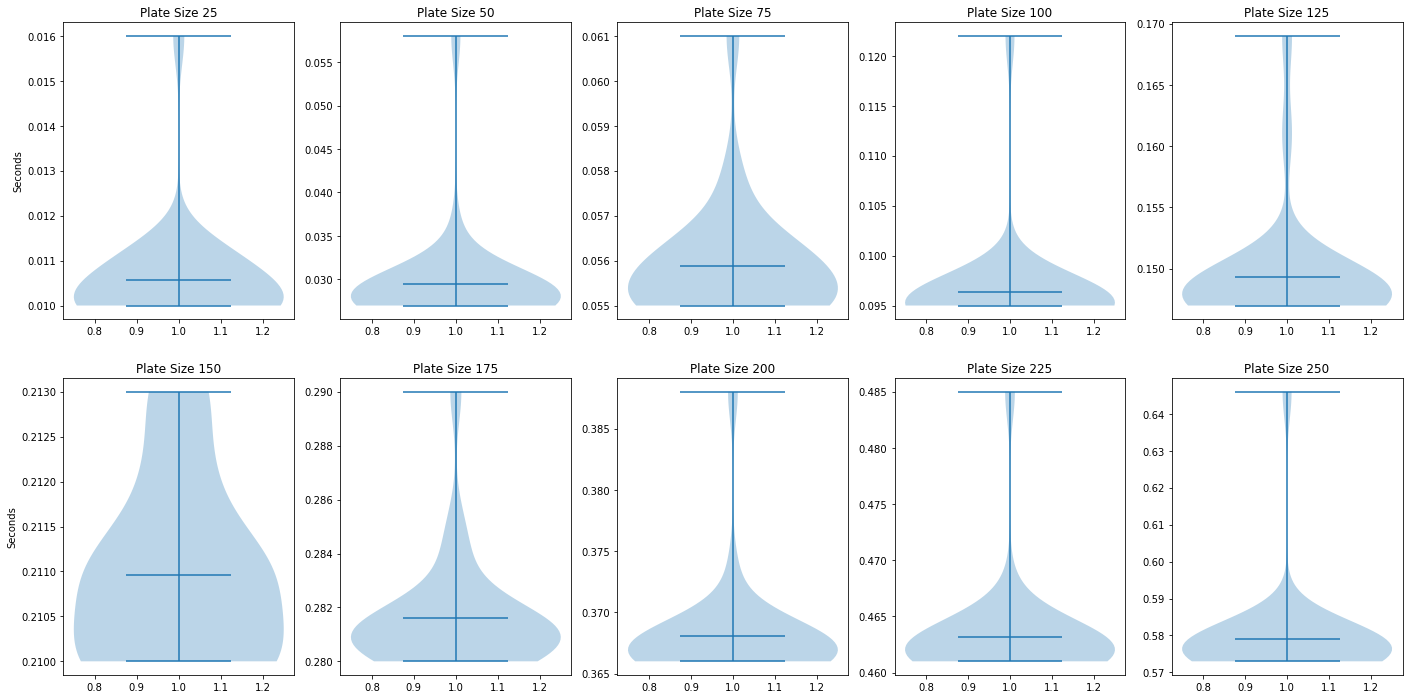

In [76]:
graph_results('serial\\serial_times\\')

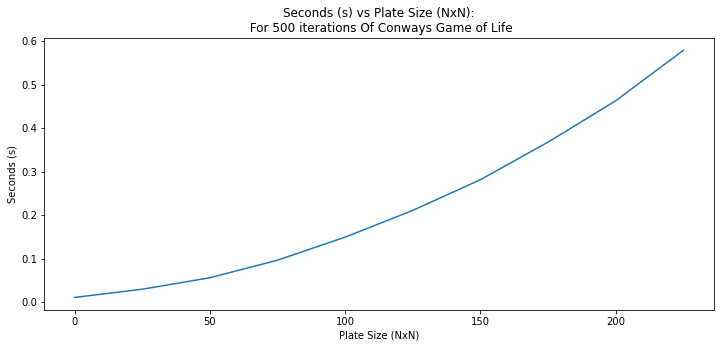

In [77]:
av_serial_times = times(10, 'serial\\serial_times\\')
plt.figure(figsize = (12,5))
line_plot(av_serial_times, 10)

As you can see the serial code has a quadratic curve and already by the time we get to an image of 250X250 pixels it starts to take almost a second to compile.  

## Compiler Optimization

All I decided to do with this was to change the optimization flag to -O3 and abandoned writing to an image, I decided to do this because I had changed the code so much for the CUDA speedup that I was unable to get the PNG function to work. However we are only trying to compare how long it takes for the program to iterate through conways game at different plate sizes so getting rid of the write to png actually helps our cause here, and we are better able to compare the true computational advantages of both programs.

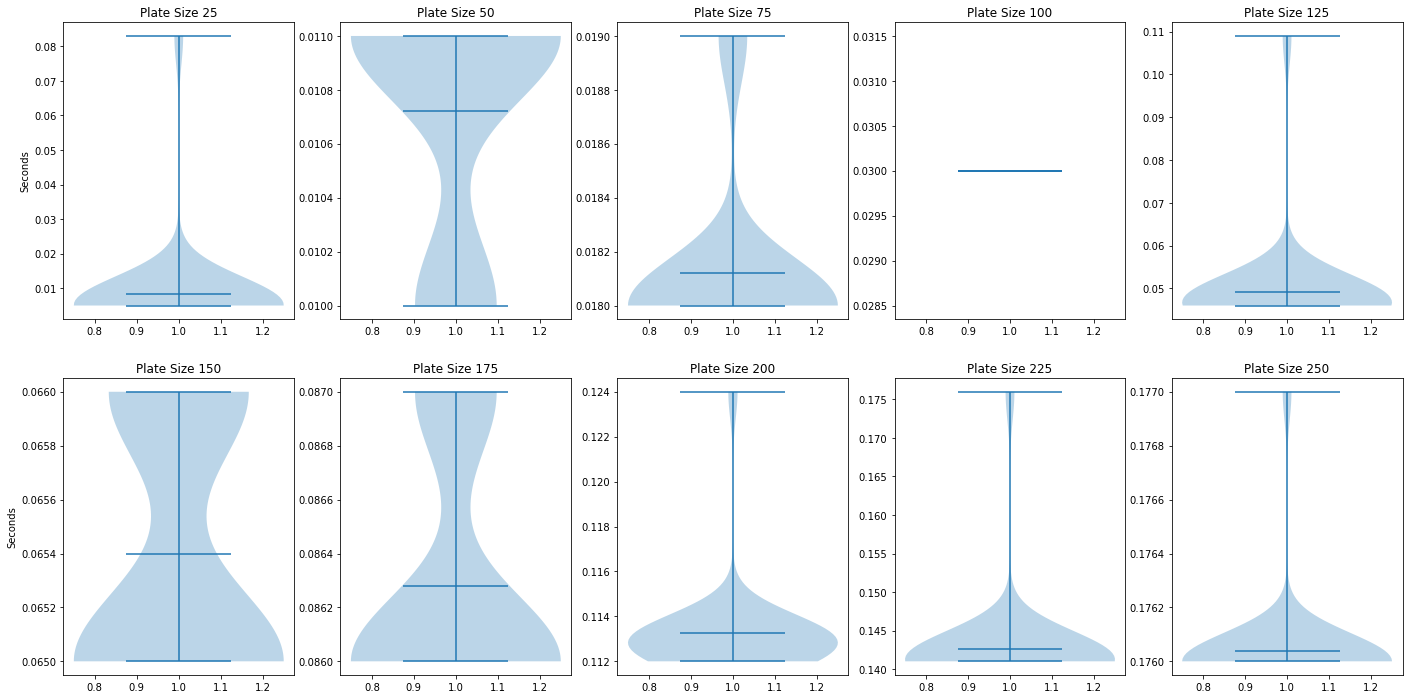

In [78]:
graph_results('serial_optimized\\serial_optimized_times\\')

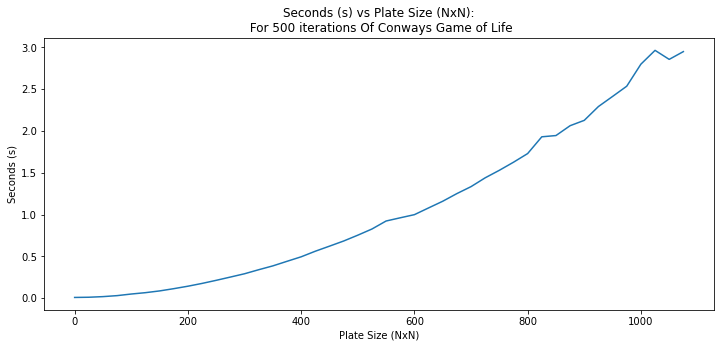

In [85]:
av_optimized_times = times(44, 'serial_optimized\\serial_optimized_times\\')
plt.figure(figsize = (12,5))
line_plot(av_optimized_times, 44)

As you can see this is a major improvement to the speedup, further speedups that could have been done, would have been getting rid of all print statements although it probaly would not have been noticeable.

## CUDA Speedup

https://www.olcf.ornl.gov/tutorials/cuda-game-of-life/

I had to change the c code live functions and iteration functions, I found similar c code from Oak Ridge Labs and this helped guide me to re-writing the code. It was really hard to read because of the which variable from the original source and the game rules were not implemented as clearly. To transform the c code into the cuda code I made many changes, I found it much easier to set up the matrices in my head as such
Lines 90-100 in gameoflife.cu:

    // Allocate memory for plates
    int array_length = ((n+2)*(n+2));
	size_t nBytes = sizeof(int)*array_length;

	int *first_plate, *second_plate, *tmp_plate;
	cudaMallocManaged(&first_plate, nBytes);
	cudaMallocManaged(&second_plate, nBytes);
	cudaMallocManaged(&tmp_plate, nBytes);

The tmp_plate being an intermediary between plates during the main loop as I iterate forward.
I didn't copy everything however from oak ridge labs, I found their extra kernels unnecessary and I did not like the way they setup their dimensions for solving the problem. I completely ignored these changes and setup my threads as 32x32 to take advantage of entire blocks, and I configured blocks as the following
Lines 116-120:

    int threads = 32; // 32X32 Maximum threads per Block
	int blocks = (n+threads - 1)/threads;
	dim3 THREADS(threads, threads);
	dim3 BLOCKS(blocks, blocks);

Finally I was not able to get the png function to work again due to lack of time, but I don't see this as a major problem due to the fact that it is unnecessary for the point of the project: that being computationn time of GPU vs CPU for the problem itself

The final loop looked as such:

    for(int i = 0; i < M; i++){
        iterateLive<<<BLOCKS, THREADS>>>(n, first_plate, second_plate);
        cudaDeviceSynchronize();

        tmp_plate = first_plate;
        first_plate = second_plate;
        second_plate = tmp_plate;

        printf("\nIteration %d:\n",i);
    }

for my sbatch commands all I did was add the GPU flag:

    #!/bin/bash --login
    #SBATCH --nodes=1
    #SBATCH --mem-per-cpu=10000
    #SBATCH --cpus-per-task=1
    #SBATCH --time=00:10:00
    #SBATCH --gpus=1

    module load CUDA



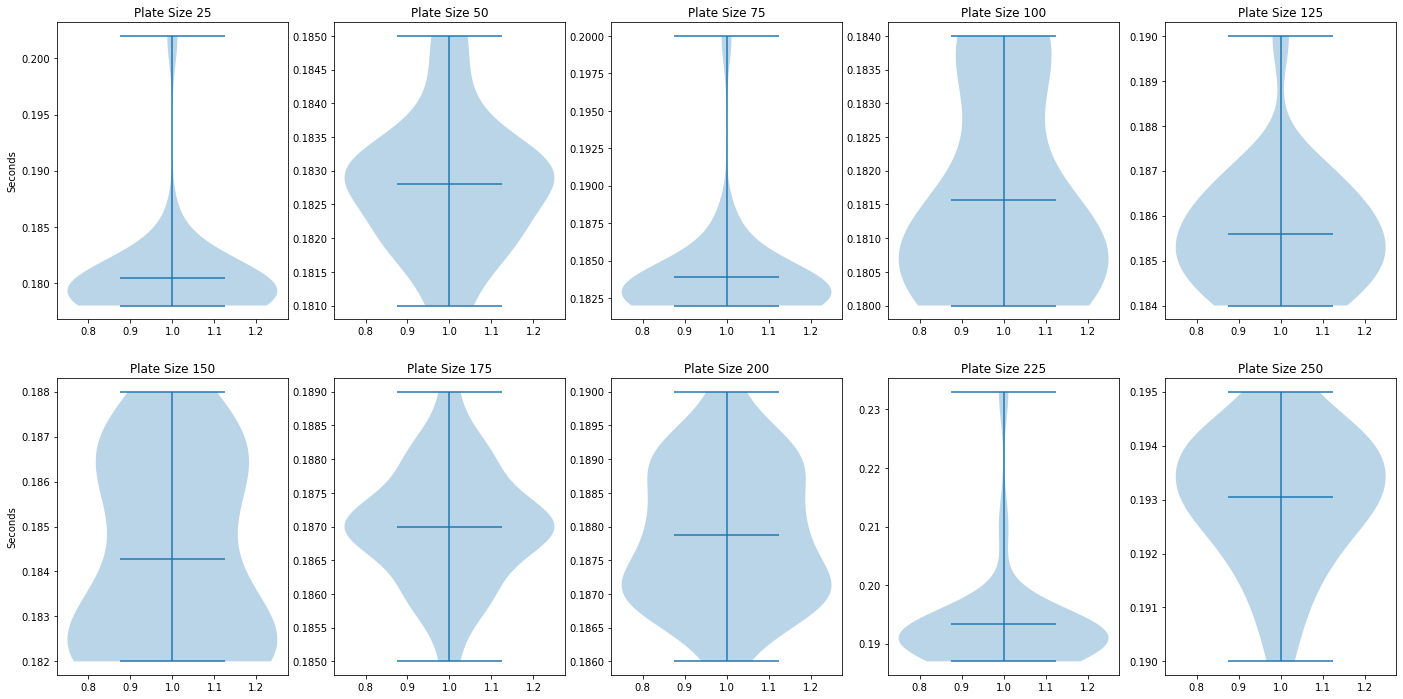

In [86]:
graph_results('cuda\\cuda_times\\')

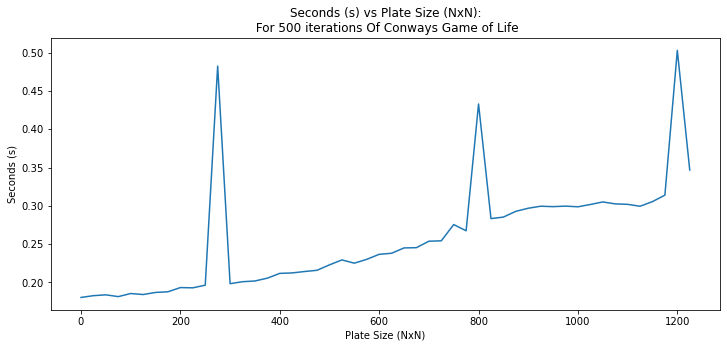

In [87]:
av_cuda_times = times(50, 'cuda\\cuda_times\\')
plt.figure(figsize = (12,5))
line_plot(av_cuda_times, 50)

I think its simply amazing that we converted a problem that takes O(n^2) to complete, to a problem that almost seems to take O(n). This makes sense to me becuase we are physically mapping our threads and blocks onto the GPU at the same rate as the problem size increases as such it reduces to a linear time scale.

I do not understand where the spikes come from but it is probably an issue with the edges of blocks and threads overlapping with the problem size and needing to reallocate memory.

## Concluding Discussion

Describe what you learned during this process, what worked, what didn't work, where did you have trouble and what you learned

I had big issues figuring out how to get the kernel appropriately adjusted. I still find it confusing how the loops can change and what to keep the same and what to change in the kernel, it is good that I found good resources but I would like to continue working on problems such as these in my own time due to their interesting capabilities.

I did not have enough time to inlude tiling so that is probably the first thing I can do to significantly improve the code, as we can see below, for small problem sizes the cpus outperform the GPU from around 25-100 for the serial and 25-225 for the serial optimized.  

In [ ]:
plt.figure(figsize = (12,5))
line_plot(av_cuda_times, 50)
line_plot(av_optimized_times, 44)
line_plot(av_serial_times, 10)

----